# **Current Population Survey**

In [65]:
import numpy as np
from numpy.linalg import inv
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [66]:
warnings.filterwarnings('ignore')

In [67]:
# Current Population Survey (CPS) dataset
cps = pd.read_excel('../data/cps09mar/cps09mar.xlsx')

In [86]:
# Add columns of individual experience and wage respectively.
cps['experience'] = cps.age - cps.education - 6
cps['wage'] = cps.earnings.div(cps.hours * cps.week)

In [87]:
cps.info() # print information of CPS dataset.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50742 entries, 0 to 50741
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         50742 non-null  int64  
 1   female      50742 non-null  int64  
 2   hisp        50742 non-null  int64  
 3   education   50742 non-null  int64  
 4   earnings    50742 non-null  int64  
 5   hours       50742 non-null  int64  
 6   week        50742 non-null  int64  
 7   union       50742 non-null  int64  
 8   uncov       50742 non-null  int64  
 9   region      50742 non-null  int64  
 10  race        50742 non-null  int64  
 11  marital     50742 non-null  int64  
 12  experience  50742 non-null  int64  
 13  wage        50742 non-null  float64
dtypes: float64(1), int64(13)
memory usage: 5.4 MB


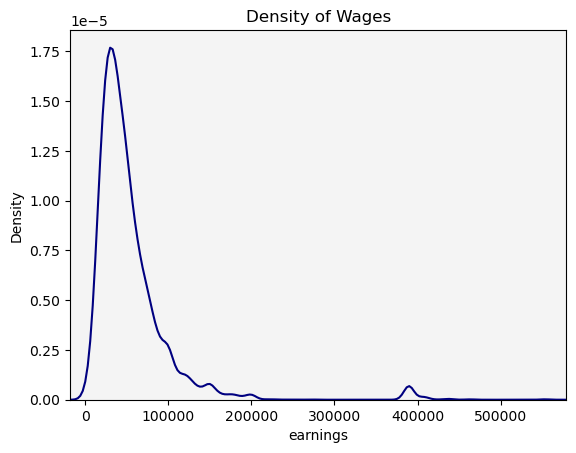

In [70]:
# Figure 2.1: Density of Wages
fig, ax = plt.subplots()

sns.kdeplot(cps, x='earnings', color='navy', ax=ax)

ax.set_title('Density of Wages')
ax.set_facecolor('#F4F4F4')
ax.set_xmargin(0)

plt.show()

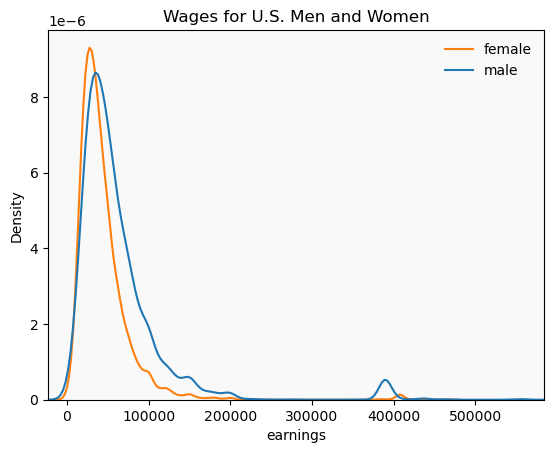

In [72]:
# Figure 2.1: Density of Wages
fig, ax = plt.subplots()

sns.kdeplot(cps, x='earnings', hue='female', ax=ax, legend=False)

ax.set_title('Wages for U.S. Men and Women')
ax.set_facecolor('#F9F9F9')
ax.set_xmargin(0)
ax.legend(['female', 'male'], frameon=False)

plt.show()

## **Conditional Expectation Function**

In [ ]:
def conditional_expectation(x, y, data, support='discrete'):
    
    cef = []
    
    if support == 'discrete':
        df = data.loc[data]

In [208]:
def cmean(Y, X):
    xs = np.sort(X.unique())
    cms = []
    
    for x in xs:
        cms.append(np.mean(Y[X==x]))

    return cms

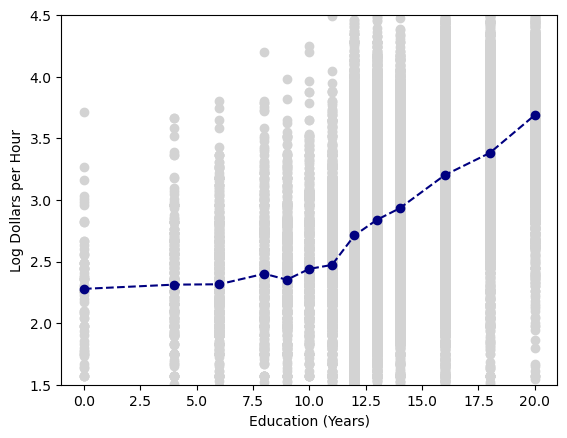

In [217]:
X = cps.education # years of education
Y = np.log(cps.earnings.div(cps.hours * cps.week)) # log wage
cm = cmean(Y, X) # Conditional mean of Y given X

fig, ax = plt.subplots()

ax.scatter(x, y, color='lightgray')
ax.plot(np.sort(x.unique()), cm, color='navy', ls='--', marker='o')

ax.set_xlabel('Education (Years)')
ax.set_ylabel('Log Dollars per Hour')
ax.set_ylim((1.5, 4.5))

plt.show()

In [201]:
np.sort(x.unique())

array([ 0,  4,  6,  8,  9, 10, 11, 12, 13, 14, 16, 18, 20], dtype=int64)

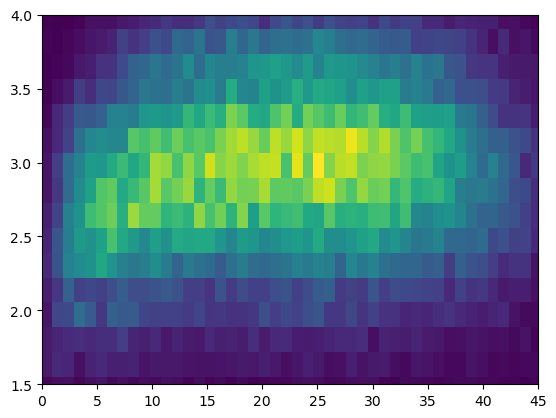

In [194]:
# Bivariate Distribution

x = cps.age - cps.education - 6 # Experience
y = np.log(cps.earnings.div(cps.hours * cps.week)) # log wage

fig, ax = plt.subplots()

h, xbins, ybins, _ = ax.hist2d(x, y, bins=80)

ax.set_xlim((0, 45))
ax.set_ylim((1.5, 4))

plt.show()

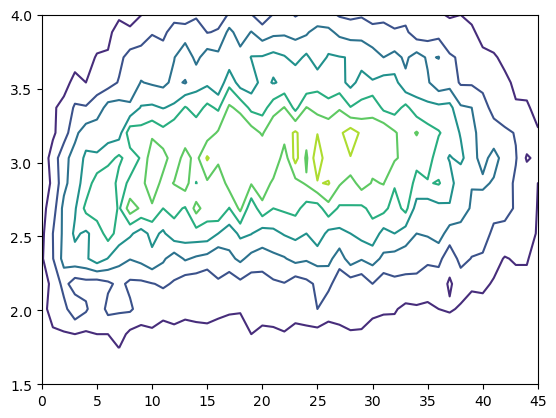

In [195]:

fig, ax = plt.subplots()
ax.contour(np.transpose(h), extent=[xbins.min(), xbins.max(), ybins.min(), ybins.max()])

ax.set_xlim((0, 45))
ax.set_ylim((1.5, 4))

plt.show()

## **3.7. Illustration**

In [73]:
# Example 1
# Construct sub-sample of married (spouse present) Black female wage earners with 12 years potential work experience.
married = cps.marital.isin([1, 2])
black = cps.race==2
female = cps.female==1
experience = cps.experience == 12
cond = married & black & female & experience

subsample = cps[cond].reset_index(drop=True)
subsample['wage'] = subsample.earnings.div(subsample.hours * subsample.week)

# Construct dataset as Table 3.1 of Hansen (2022)
obs = pd.concat([subsample.wage, 
                 np.log(subsample.wage).rename('lwage'),
                 subsample.education.rename('educ'),
                 (subsample.education**2).rename('educsq'),
                 (subsample.education*np.log(subsample.wage)).rename('edxlw')], axis=1)

In [74]:
obs.sum()

wage       514.593606
lwage       62.638508
educ       314.000000
educsq    5010.000000
edxlw      995.858690
dtype: float64

In [75]:
Y = obs.lwage # log(wage)
X = pd.concat([obs.educ, pd.Series(np.ones(20), name='const')], axis=1) # years of education and an intercept

In [76]:
Qxy = X.T @ Y # ΣXY
Qxx = X.T @ X # ΣXX'

print(Qxy)
print(Qxx)

educ     995.858690
const     62.638508
dtype: float64
         educ  const
educ   5010.0  314.0
const   314.0   20.0


In [77]:
β_hat = inv(Qxx) @ Qxy

print(β_hat) # first element denotes the slope coefficient while second one denotes the intercept coefficient.

[0.15503888 0.69781503]


In [93]:
# Example 2
# Construct sub-sample of single (never married) Asian men.
subsample = cps.loc[(cps.marital==7) & (cps.race==4) & (cps.female==0)].reset_index(drop=True)
n = len(subsample)

# Define regressors and a dependent variable.
X = pd.concat([subsample.education.rename('educ'), # years of education
               subsample.experience.rename('expr'), # years of potential work experience
               ((subsample.experience**2)/100).rename('exprsq'), # squared years of potential work experience divided by 100
               pd.Series(np.ones(n)).rename('const')], axis=1)
Y = np.log(subsample.wage).rename('lwage')

# Compute β_hat
β_hat = inv(X.T @ X) @ (X.T @ Y)
print(β_hat)

[ 0.14331647  0.03557892 -0.07137808  0.5753563 ]


In [150]:
def beta_ols(Y, X):
    # Assume X is not ill-conditioned.
    return inv(X.T @ X) @ (X.T @ Y)
    
def ols_residuals(Y, X):
    beta = beta_ols(Y, X)
    return Y - X @ beta

def projection_matrix(X):
    """
    Return a projection matrix of given matrix form of regressors.
    """
    return X @ inv(X.T @ X) @ X.T

def annihilator_matrix(X):
    """
    Return an annihilator matrix of given matrix form of regressors.
    """
    return np.eye(len(X)) - X @ inv(X.T @ X) @ X.T

def leverage_values(P):
    return np.diag(P)

In [143]:
e = ols_residuals(Y, X.values)
P = projection_matrix(X.values) # Projection matrix
M = annihilator_matrix(X.values) # Annihilator matrix
h = leverage_values(P) # the leverage values

In [149]:
np.max(np.abs(h * e / (1-h)))

0.29263960659349236